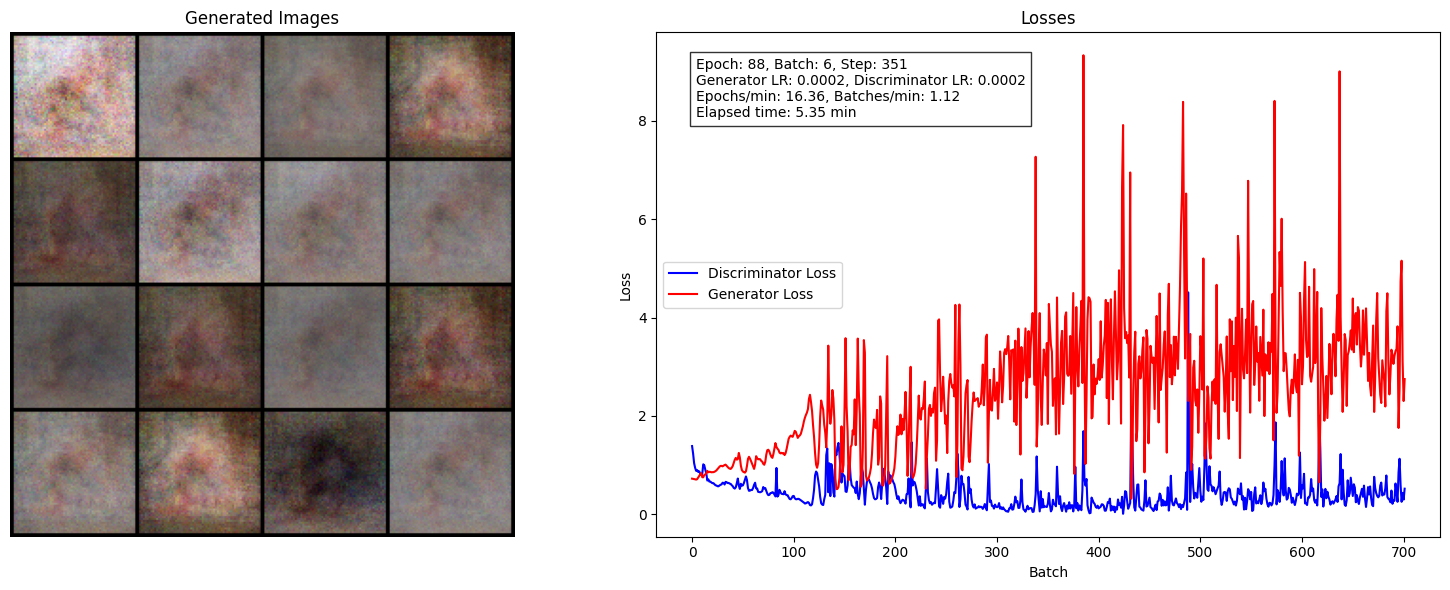

In [ ]:
import os
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from datasets import load_dataset
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
latent_dim = 100
batch_size = 64
lr = 0.0002
epochs = 2000
image_size = 64  # Resize images to 64x64
num_channels = 3  # For RGB images

# Path to your image folder
image_folder = "D:\\Diffusion\\Training\\_datasets\\dreamweaver\\cont\\backbend-chest-side"


# Supported image extensions
valid_extensions = {'.jpg', '.jpeg', '.png'}

# Custom dataset loader that filters supported image files
class FilteredImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform)
        # Filter out files without valid extensions
        self.samples = [(path, label) for path, label in self.samples if self._is_valid_file(path)]
    
    def _is_valid_file(self, path):
        return os.path.splitext(path)[1].lower() in valid_extensions
    

def collate_fn(batch):
    images = [transform(item['image']) for item in batch]
    return torch.stack(images)

# Use the custom collate_fn in the DataLoader



# Generator for color images
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, image_size * image_size * num_channels),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), num_channels, image_size, image_size)
        return x


# Discriminator for color images
# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# Discriminator for color images
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size * image_size * num_channels, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)  # No sigmoid here; BCEWithLogitsLoss applies it


# Transform to normalize the data and resize images
transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),  # Ensure RGB format
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * num_channels, [0.5] * num_channels)
])

# Load images from folder
dataset = load_dataset("imagefolder", data_dir=image_folder, split="train")

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

# Instantiate generator and discriminator
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

# Define loss function
#criterion = nn.BCELoss()

lrd = 0.0002
lrg = 0.0002
# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lrg, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lrd, betas=(0.5, 0.999))



# Lists to store losses for plotting
d_losses = []
g_losses = []
# Initialize counters and timer
start_time = time.time()
step_count = 0
# Function to display generated images
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Function to display generated images inline and keep them in place
def show_images_and_loss(generator, d_losses, g_losses, epoch, batch, lr_G, lr_D):
    global step_count
    step_count += 1
    elapsed_time = time.time() - start_time
    batches_per_minute = (batch + 1) / (elapsed_time / 60)
    epochs_per_minute = (epoch + (batch / len(dataloader))) / (elapsed_time / 60)
    
    generator.eval()
    with torch.no_grad():
        z = torch.randn(16, latent_dim).to(device)
        fake_images = generator(z).cpu()
        grid = make_grid(fake_images, nrow=4, normalize=True)

        clear_output(wait=True)
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Display generated images
        axes[0].imshow(grid.permute(1, 2, 0))
        axes[0].axis("off")
        axes[0].set_title("Generated Images")
        
        # Plot losses
        axes[1].plot(d_losses, label='Discriminator Loss', color='blue')
        axes[1].plot(g_losses, label='Generator Loss', color='red')
        axes[1].legend()
        axes[1].set_title("Losses")
        axes[1].set_xlabel("Batch")
        axes[1].set_ylabel("Loss")

        # Additional information
        info_text = (
            f"Epoch: {epoch+1}, Batch: {batch+1}, Step: {step_count}\n"
            f"Generator LR: {lr_G}, Discriminator LR: {lr_D}\n"
            f"Epochs/min: {epochs_per_minute:.2f}, Batches/min: {batches_per_minute:.2f}\n"
            f"Elapsed time: {elapsed_time/60:.2f} min"
        )
        axes[1].text(0.05, 0.95, info_text, transform=axes[1].transAxes, fontsize=10,
                     verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))

        plt.tight_layout()
        plt.show()


scaler = torch.cuda.amp.GradScaler()
criterion = nn.BCEWithLogitsLoss()
dtype = torch.bfloat16
for epoch in range(epochs):
    for i, real_images in enumerate(dataloader):
        real_images = real_images.to(device, dtype=dtype)
        batch_size = real_images.size(0)
        real_labels = torch.ones(batch_size, 1, device=device, dtype=dtype)
        fake_labels = torch.zeros(batch_size, 1, device=device, dtype=dtype)

        # Train Discriminator with AMP and BCEWithLogitsLoss
        optimizer_D.zero_grad()
        with torch.cuda.amp.autocast(dtype=dtype):
            outputs = discriminator(real_images)
            d_loss_real = criterion(outputs, real_labels)

            z = torch.randn(batch_size, latent_dim, device=device, dtype=dtype)
            fake_images = generator(z)
            outputs = discriminator(fake_images.detach())
            d_loss_fake = criterion(outputs, fake_labels)
            d_loss = d_loss_real + d_loss_fake

        scaler.scale(d_loss).backward()
        scaler.step(optimizer_D)
        scaler.update()

        # Train Generator with AMP and BCEWithLogitsLoss
        optimizer_G.zero_grad()
        with torch.cuda.amp.autocast(dtype=dtype):
            z = torch.randn(batch_size, latent_dim, device=device, dtype=dtype)
            fake_images = generator(z)
            outputs = discriminator(fake_images)
            g_loss = criterion(outputs, real_labels)

        scaler.scale(g_loss).backward()
        scaler.step(optimizer_G)
        scaler.update()
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())


        if (i+1) % 2 == 0:
             show_images_and_loss(generator, d_losses, g_losses, epoch, i, lr_G=lrg, lr_D=lrd)

    print(f"Epoch [{epoch+1}/{epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}")

    
